In [112]:
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
from sklearn import datasets


# Set the image face matrix directory here
faceDir = "D:\\study\\19spr\\math 490\\faces"

In [113]:
# RSVD --- Two Pass
# Taken from Randomized methods for matrix computations by Per-Gunnar Martinsson
# Page 9 Figure 1

def Fig1_svd(A, k, p):
    """
    A = QQ'A = QB = QUhatDV' = UDV'
    parameters:
        A - m*n matrix
        k - target rank
        p - over-sampling parameter
    Outputs:
        matrices U,D,V in an approximate rank-(k+p) svd of A
    """
    m, n = A.shape
    # form an n*(k + p) Gaussian random matrix G
    G = np.random.rand(n, k+p)
    # form the sample matrix Y = AG.
    Y = A@G
    # orthonormalize the columns of the sample matrix Q = orth(Y)
    Q = linalg.orth(Y)
    # form the (k + p) * n matrix B = Q'*A
    B = Q.T@A
    # form the svd of the small matrix B
    Uhat, D, Vt = np.linalg.svd(B, full_matrices=False)
    V = Vt.T
    # drop the last p components
    Uhat = Uhat[:,:k]; D = D[:k]; V = V[:,:k];
    # form U = Q * Uhat
    U = Q@Uhat
    return U, D, V, Q

In [114]:
# Single-pass randomized svd v1.0
# Taken from Randomized methods for matrix computations by Per-Gunnar Martinsson
# Page 12 Figure 3
def Fig3_svd_1(A, k, p):
    # Stage A
    m, n = A.shape
    G_c = np.random.randn(n, k+p)
    G_r = np.random.randn(m, k+p)
    Y_c = A @ G_c
    Y_r = np.transpose(A) @ G_r
    # potential source of error
    Q_c = linalg.orth(Y_c)
    Q_c = Q_c[:,:k]
    Q_r = linalg.orth(Y_r)
    Q_r = Q_r[:,:k]
    # Stage B
    # construct the linear system
    G = np.bmat([[G_r.T@Q_c,np.zeros((k+p,k))],[np.zeros((k+p,k)),G_c.T@Q_r],[np.eye(k),-np.eye(k)]])
    H = np.vstack((Y_r.T@Q_r,Y_c.T@Q_c,np.zeros((k,k))))
    CCT = np.linalg.lstsq(G,H,rcond = None)[0]
    C = CCT[:k,:]
    uh, D, vh = np.linalg.svd(C, full_matrices=False)
    U = Q_c @ uh
    V = Q_r @ vh.T
    return U, D, V, Q_c, Q_r

In [115]:
# Single-pass randomized svd v2.0
# The change is that we instead of solving the system of equations, we take the smalles residuals from the least square solution
# This change is mentioned in the paper as well
# from the analysis below, we can see that version 2.0 performs better in terms of speed.
def Fig3_svd(A, k, p):
    # Stage A
    m, n = A.shape
    G_c = np.random.randn(n, k+p)
    G_r = np.random.randn(m, k+p)
    Y_c = A @ G_c
    Y_r = np.transpose(A) @ G_r
    # potential source of error
    Q_c = linalg.orth(Y_c)
    Q_c = Q_c[:,:k]
    Q_r = linalg.orth(Y_r)
    Q_r = Q_r[:,:k]
    # Stage B
    # construct the linear system
    c1,r1 = np.linalg.lstsq(G_r.T@Q_c,Y_r.T@Q_r,rcond=None)[:2]
    c2,r2 = np.linalg.lstsq(G_c.T@Q_r,Y_c.T@Q_c,rcond=None)[:2]
    if np.linalg.norm(r1,2) < np.linalg.norm(r2,2):
        C = c1
    else:
        C = c2.T
    uh, D, vh = np.linalg.svd(C, full_matrices=False)
    U = Q_c @ uh
    V = Q_r @ vh.T
    return U, D, V, Q_c, Q_r

In [116]:
# Classical svd
def classical(A, k):
    """
    Given an m × n matrix A and integers k,
    generates low-rank approximation and error.
    """
    u, d, v = np.linalg.svd(A, full_matrices=False)
    return u[:,:k], d[:k], v[:,:k], d[k]

In [87]:
# Posteriori error estimate function
# Taken from Randomized methods for matrix computations by Per-Gunnar Martinsson
# Page 28 Section 14
# and Finding Structure with Randomness by N. Halko P. G. Martinsson J. A. Tropp
# Section 4.3 
def esti_error(A,Q,r):
    # draw a sequence of standard Guassian vectors
    # generate the estimated error and probability
    m, n = A.shape
    error = 10*np.sqrt(2/np.pi)*max([np.linalg.norm(A@np.random.rand(n)-Q@(Q.T@(A@np.random.rand(n))),2) for i in range(r)])
    p = 1 - 10**(-r)
    return error, p
# Provides a cheap upper bound on the possible error

# Computational cost analysis

Text(0.5, 1.0, 'Computational Time')

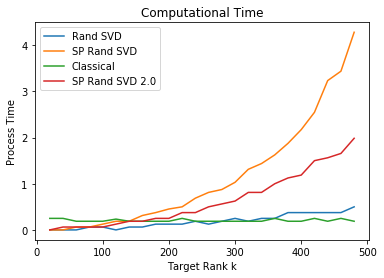

In [17]:
# Computational cost analysis for fixed matrix and fixed p
A = np.random.rand(500,500)
p = 10
time_cost_1 = []
time_cost_2 = []
time_cost_3 = []
time_cost_4 = []
for k in range(20,500,20):
    start_time_3 = time.process_time()
    classical(A,k)
    cost3 = time.process_time() - start_time_3
    time_cost_3.append(cost3)
    start_time_1 = time.process_time()
    Fig1_svd(A,k,p)
    cost1 = time.process_time() - start_time_1
    time_cost_1.append(cost1)
    start_time_2 = time.process_time()
    Fig3_svd_1(A,k,p)
    cost2 = time.process_time() - start_time_2
    time_cost_2.append(cost2)
    start_time_4 = time.process_time()
    Fig3_svd(A,k,p)
    cost4 = time.process_time() - start_time_4
    time_cost_4.append(cost4)
plt.plot(range(20,500,20),time_cost_1,label='Rand SVD')
plt.plot(range(20,500,20),time_cost_2,label='SP Rand SVD')
plt.plot(range(20,500,20),time_cost_3,label='Classical')
plt.plot(range(20,500,20),time_cost_4,label='SP Rand SVD 2.0')
plt.legend()
plt.xlabel('Target Rank k')
plt.ylabel('Process Time')
plt.title('Computational Time')

Text(0.5, 1.0, 'Computational Time')

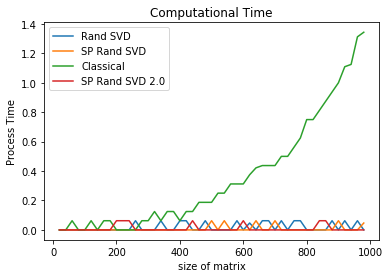

In [20]:
# computational cost for fixed k
p = 10
k = 10
time_cost_1 = []
time_cost_2 = []
time_cost_3 = []
time_cost_4 = []
for i in range(20,1000,20):
    A = np.random.rand(i,i)
    start_time_3 = time.process_time()
    classical(A,k)
    cost3 = time.process_time() - start_time_3
    time_cost_3.append(cost3)
    start_time_1 = time.process_time()
    Fig1_svd(A,k,p)
    cost1 = time.process_time() - start_time_1
    time_cost_1.append(cost1)
    start_time_2 = time.process_time()
    Fig3_svd_1(A,k,p)
    cost2 = time.process_time() - start_time_2
    time_cost_2.append(cost2)
    start_time_4 = time.process_time()
    Fig3_svd(A,k,p)
    cost4 = time.process_time() - start_time_4
    time_cost_4.append(cost4)
plt.plot(range(20,1000,20),time_cost_1,label='Rand SVD')
plt.plot(range(20,1000,20),time_cost_2,label='SP Rand SVD')
plt.plot(range(20,1000,20),time_cost_3,label='Classical')
plt.plot(range(20,1000,20),time_cost_4,label='SP Rand SVD 2.0')
plt.legend()
plt.xlabel('size of matrix')
plt.ylabel('Process Time')
plt.title('Computational Time')

Text(0.5, 1.0, 'Computational Time')

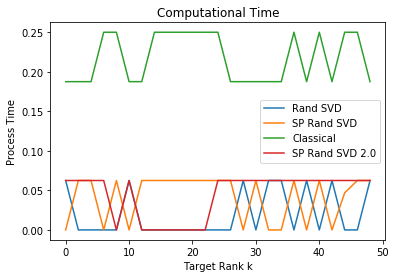

In [63]:
# Computational cost analysis for fixed matrix and fixed k
A = np.random.rand(500,500)
k = 50
time_cost_1 = []
time_cost_2 = []
time_cost_3 = []
time_cost_4 = []
for p in range(0,50,2):
    start_time_3 = time.process_time()
    classical(A,k)
    cost3 = time.process_time() - start_time_3
    time_cost_3.append(cost3)
    start_time_1 = time.process_time()
    Fig1_svd(A,k,p)
    cost1 = time.process_time() - start_time_1
    time_cost_1.append(cost1)
    start_time_2 = time.process_time()
    Fig3_svd_1(A,k,p)
    cost2 = time.process_time() - start_time_2
    time_cost_2.append(cost2)
    start_time_4 = time.process_time()
    Fig3_svd(A,k,p)
    cost4 = time.process_time() - start_time_4
    time_cost_4.append(cost4)
plt.plot(range(0,50,2),time_cost_1,label='Rand SVD')
plt.plot(range(0,50,2),time_cost_2,label='SP Rand SVD')
plt.plot(range(0,50,2),time_cost_3,label='Classical')
plt.plot(range(0,50,2),time_cost_4,label='SP Rand SVD 2.0')
plt.legend()
plt.xlabel('Target Rank k')
plt.ylabel('Process Time')
plt.title('Computational Time')

# Approximation error analysis

In [88]:
# make two artificial rank-specific matrix
A = datasets.make_low_rank_matrix(500,200,30)
B = datasets.make_low_rank_matrix(500,200,150)

In [10]:
# compute matrix induced 2-norm for the difference between input matrix
# and approximation matrix \\(I-QQ.T)A\\
def error_exp(A,p):
    err_class=[]
    err_1=[]
    err_3_c=[]
    err_3_r=[]
    err_4_c=[]
    err_4_r=[]
    for k in range(10,200,10):
        err_class.append(classical(A,k)[3])
        Q = Fig1_svd(A,k,p)[3]
        Qc= Fig3_svd_1(A,k,p)[-2]
        Qr = Fig3_svd_1(A,k,p)[-1]
        Qc2 = Fig3_svd(A,k,p)[-2]
        Qr2 = Fig3_svd(A,k,p)[-1]
        err_3_c.append(np.linalg.norm(A-Qc@Qc.T@A,2))
        err_3_r.append(np.linalg.norm(A-A@Qr@Qr.T,2))
        err_4_c.append(np.linalg.norm(A-Qc2@Qc2.T@A,2))
        err_4_r.append(np.linalg.norm(A-A@Qr2@Qr2.T,2))
        err_1.append(np.linalg.norm(A-Q@Q.T@A,2))
    return err_class,err_1,err_3_c,err_3_r,err_4_c,err_4_r

In [9]:
# Test on low rank matrix
err_class,err_1,err_3_c,err_3_r=error_exp(A,5)[:4]
err_class_10,err_1_10,err_3_c_10,err_3_r_10=error_exp(A,10)[:4]

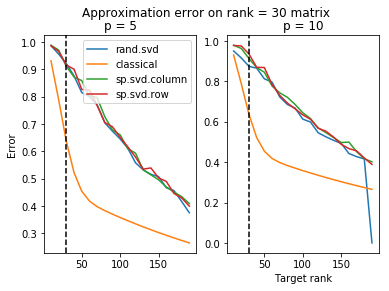

In [14]:
# For low rank matrix, randomized svd has lower accuracy than classical svd
# two randomized svd has similar error but RSVD seems to perform a bit better when p = 10
ax1=plt.subplot(121);ax2=plt.subplot(122)
ax1.plot(range(10,200,10),err_1,label='rand.svd')
ax1.plot(range(10,200,10),err_class,label='classical')
ax1.plot(range(10,200,10),err_3_c,label='sp.svd.column')
ax1.plot(range(10,200,10),err_3_r,label='sp.svd.row')
ax1.legend(loc=0)
ax1.set_title('p = 5')
ax1.set_ylabel('Error')
plt.suptitle('Approximation error on rank = 30 matrix')
ax1.axvline(x=30,linestyle='--',color='k')
ax2.plot(range(10,200,10),err_1_10,label='rand.svd')
ax2.plot(range(10,200,10),err_class_10,label='classical')
ax2.plot(range(10,200,10),err_3_c_10,label='sp.svd.column')
ax2.plot(range(10,200,10),err_3_r_10,label='sp.svd.row')
ax2.set_title('p = 10')
ax2.set_xlabel('Target rank')
ax2.axvline(x=30,linestyle='--',color='k')

Text(0.5, 0.98, 'Approximation error on rank = 150 matrix')

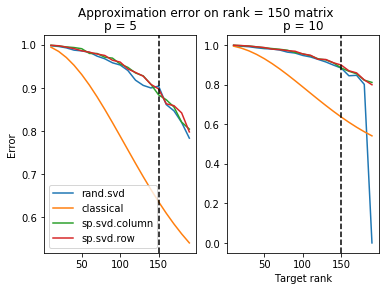

In [15]:
# test on high rank matrix
# in general, classical >> RSVD > single-pass
err_class,err_1,err_3_c,err_3_r=error_exp(B,5)[:4]
err_class_10,err_1_10,err_3_c_10,err_3_r_10=error_exp(B,10)[:4]
ax1=plt.subplot(121);ax2=plt.subplot(122)
ax1.plot(range(10,200,10),err_1,label='rand.svd')
ax1.plot(range(10,200,10),err_class,label='classical')
ax1.plot(range(10,200,10),err_3_c,label='sp.svd.column')
ax1.plot(range(10,200,10),err_3_r,label='sp.svd.row')
ax1.legend(loc=0)
ax1.set_title('p = 5')
ax1.set_ylabel('Error')
ax1.axvline(x=150,linestyle='--',color='k')
ax2.plot(range(10,200,10),err_1_10,label='rand.svd')
ax2.plot(range(10,200,10),err_class_10,label='classical')
ax2.plot(range(10,200,10),err_3_c_10,label='sp.svd.column')
ax2.plot(range(10,200,10),err_3_r_10,label='sp.svd.row')
ax2.set_title('p = 10')
ax2.set_xlabel('Target rank')
ax2.axvline(x=150,linestyle='--',color='k')
plt.suptitle('Approximation error on rank = 150 matrix')

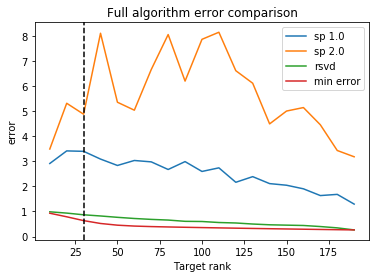

In [101]:
# try to compare approximation error between two versions of sinlge-pass algorithm
# and turns out version 1.0 has a smaller error.
r1 = []; r2 = [];m=[];s =[]
for k in range(10,200,10):
    u1,d1,v1 = Fig3_svd_1(A,k,10)[:3]
    u2,d2,v2 = Fig3_svd(A,k,10)[:3]
    u3,d3,v3 = Fig1_svd(A,k,19)[:3]
    min_e = classical(A,k)[-1]
    r1.append(np.linalg.norm(A-u1@np.diag(d1)@v1.T,2))
    r2.append(np.linalg.norm(A-u2@np.diag(d2)@v2.T,2))
    m.append(np.linalg.norm(A-u3@np.diag(d3)@v3.T,2))
    s.append(min_e)
plt.plot(range(10,200,10),r1,label='sp 1.0')
plt.plot(range(10,200,10),r2,label='sp 2.0')
plt.plot(range(10,200,10),m,label='rsvd')
plt.plot(range(10,200,10),s,label='min error')
plt.title('Full algorithm error comparison')
plt.xlabel('Target rank')
plt.ylabel('error')
plt.legend(loc=0)
plt.axvline(x=30,linestyle='--',color='k')

# Eigenfaces Experiment

In [96]:
# import dataset and output as a matrix
import imageio
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import os

def imgMatrix(directory):
    # Set gather all the images in an w*h x n array
    imgMatrix = []
    for imgName in os.listdir(directory):
        img = imageio.imread(os.path.abspath(directory) + "/" + imgName)
        img = np.transpose(np.array(img.flatten()))
        imgMatrix.append(img)
    imgMatrix = normalize(np.transpose(np.array(imgMatrix)))
    return imgMatrix

In [97]:
faceMatrix= imgMatrix(faceDir)
faceMatrix=faceMatrix-np.mean(faceMatrix,axis=1).reshape(77760,1)
#faceMatrix.shape

In [29]:
# Perform classical svd and notice the singular value decays rapidly

In [31]:
u,d,v,e = classical(faceMatrix,163)

Text(0, 0.5, 'percentage explained')

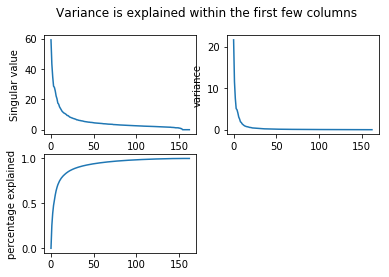

In [37]:
plt.suptitle('Variance is explained within the first few columns')
plt.subplot(221)
plt.ylabel('Singular value')
plt.xlabel('Target Rank')
plt.plot(range(len(d)),d)
plt.subplot(222)
plt.plot(range(len(d)),d**2/(163-1))
plt.ylabel('variance')
plt.subplot(223)
plt.plot(range(len(d)),[sum(d[:k]**2)/sum(d**2) for k in range(163)])
plt.ylabel('percentage explained')

In [32]:
# 89.7% of variance is explained by first 30 column vectors
sum(d[:30]**2)/sum(d**2)

0.8968368655369306

In [33]:
# doing simulation based on posterior error
def simulation(inputMat,i,g):
    error = []
    for k in range(2,30):
        Q = Fig1_svd(inputMat,k,g)[3]
        mean = np.mean([esti_error(inputMat,Q,i)[0] for j in range(100)])
        error.append(mean)
    return error

In [21]:
# if you want to run the code below, please come back 15 min later.
# this part of error estimate has abnormal behavior for some reason.

In [39]:
e5 = simulation(faceMatrix,5,5)

In [40]:
e4 = simulation(faceMatrix,5,4)

In [41]:
e3 = simulation(faceMatrix,5,3)

In [42]:
e2 = simulation(faceMatrix,5,2)

In [43]:
e1 = simulation(faceMatrix,5,1)

In [46]:
e10 = simulation(faceMatrix,5,10)

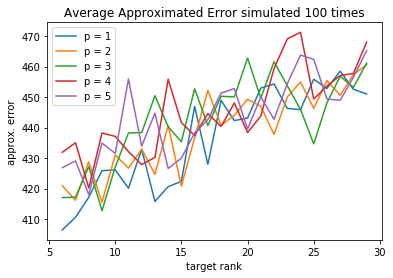

In [48]:
plt.plot(range(6,30),e1[4:],label='p = 1')
plt.plot(range(6,30),e2[4:],label='p = 2')
plt.plot(range(6,30),e3[4:],label='p = 3')
plt.plot(range(6,30),e4[4:],label='p = 4')
plt.plot(range(6,30),e5[4:],label='p = 5')
plt.xlabel('Target Rank')
plt.ylabel('Approximate Error')
plt.title('Average Approximated Error simulated 100 times')
plt.legend(loc=0)

In [52]:
def Error_ap(inputMatrix,p):
    err_class = []
    err_fig1 = []
    err_fig3 = []
    for k in range(2,30):
        e = classical(inputMatrix,k)[-1]
        u1,d1,v1 = Fig1_svd(inputMatrix,k,p)[:3]
        u2,d2,v2 = Fig3_svd(inputMatrix,k,p)[:3]
        err_class.append(e)
        err_fig1.append(np.linalg.norm(faceMatrix-u1@np.diag(d1)@v1.T,2))
        err_fig3.append(np.linalg.norm(faceMatrix-u2@np.diag(d2)@v2.T,2))
    return err_class, err_fig1, err_fig3

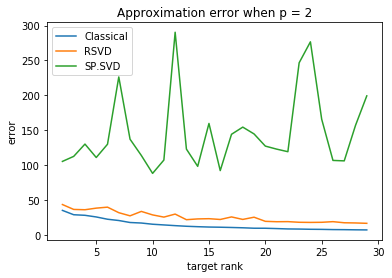

In [54]:
plt.plot(range(2,30),Error_ap(faceMatrix,2)[0],label='Classical')
plt.plot(range(2,30),Error_ap(faceMatrix,2)[1],label='RSVD')
plt.plot(range(2,30),Error_ap(faceMatrix,2)[2],label='SP.SVD')
plt.xlabel('target rank')
plt.ylabel('error')
plt.title('Approximation error when p = 2')
plt.legend(loc=0)

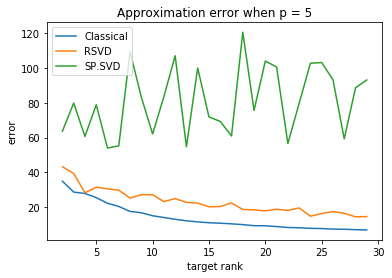

In [57]:
plt.plot(range(2,30),Error_ap(faceMatrix,5)[0],label='Classical')
plt.plot(range(2,30),Error_ap(faceMatrix,5)[1],label='RSVD')
plt.plot(range(2,30),Error_ap(faceMatrix,5)[2],label='SP.SVD')
plt.xlabel('target rank')
plt.ylabel('error')
plt.title('Approximation error when p = 5')
plt.legend(loc=0)

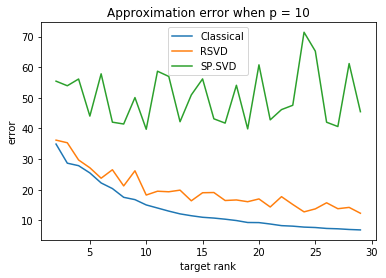

In [58]:
plt.plot(range(2,30),Error_ap(faceMatrix,10)[0],label='Classical')
plt.plot(range(2,30),Error_ap(faceMatrix,10)[1],label='RSVD')
plt.plot(range(2,30),Error_ap(faceMatrix,10)[2],label='SP.SVD')
plt.xlabel('target rank')
plt.ylabel('error')
plt.title('Approximation error when p = 10')
plt.legend(loc=0)

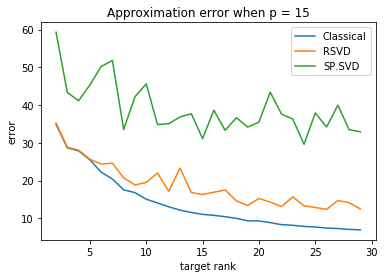

In [59]:
plt.plot(range(2,30),Error_ap(faceMatrix,15)[0],label='Classical')
plt.plot(range(2,30),Error_ap(faceMatrix,15)[1],label='RSVD')
plt.plot(range(2,30),Error_ap(faceMatrix,15)[2],label='SP.SVD')
plt.xlabel('target rank')
plt.ylabel('error')
plt.title('Approximation error when p = 15')
plt.legend(loc=0)

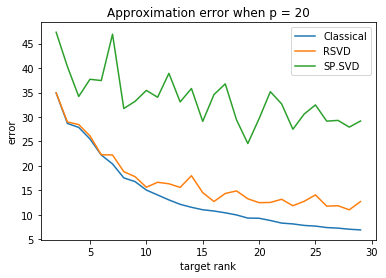

In [111]:
plt.plot(range(2,30),Error_ap(faceMatrix,20)[0],label='Classical')
plt.plot(range(2,30),Error_ap(faceMatrix,20)[1],label='RSVD')
plt.plot(range(2,30),Error_ap(faceMatrix,20)[2],label='SP.SVD')
plt.xlabel('target rank')
plt.ylabel('error')
plt.title('Approximation error when p = 20')
plt.legend(loc=0)

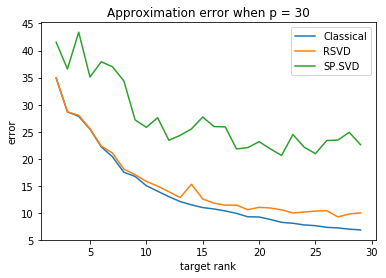

In [60]:
plt.plot(range(2,30),Error_ap(faceMatrix,30)[0],label='Classical')
plt.plot(range(2,30),Error_ap(faceMatrix,30)[1],label='RSVD')
plt.plot(range(2,30),Error_ap(faceMatrix,30)[2],label='SP.SVD')
plt.xlabel('target rank')
plt.ylabel('error')
plt.title('Approximation error when p = 30')
plt.legend(loc=0)

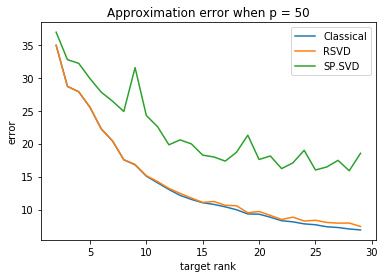

In [117]:
plt.plot(range(2,30),Error_ap(faceMatrix,50)[0],label='Classical')
plt.plot(range(2,30),Error_ap(faceMatrix,50)[1],label='RSVD')
plt.plot(range(2,30),Error_ap(faceMatrix,50)[2],label='SP.SVD')
plt.xlabel('target rank')
plt.ylabel('error')
plt.title('Approximation error when p = 50')
plt.legend(loc=0)

In [118]:
# We decide to use target rank = 15 & oversampling parameter = 30 based on these figures
# We then show the first 7 eigenfaces using the various algorithms
# Begin by getting the approximations from our algorithms
# Two pass approximation
UTwoPass, D, V,Q = Fig1_svd(faceMatrix, 15, 30)

In [119]:
# Classical approximation
UClassical,d,v0,e = classical(faceMatrix,15)

In [120]:
# Single pass approximation
USinglePass,d2,v2 = Fig3_svd_1(faceMatrix, 15, 30)[:3]

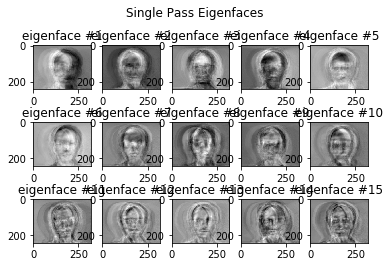

In [121]:
#  Single pass eigenfaces
for i in range(1,16):
    plt.subplot(3,5,i)
    plt.imshow((USinglePass[:,i-1]).reshape(243, 320),cmap="gray")
    plt.suptitle("Single Pass Eigenfaces")
    plt.title("eigenface #%s"%i)
plt.show()

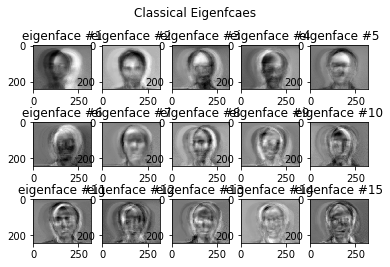

In [122]:
# Classical eigenfaces
for i in range(1,16):
    plt.subplot(3,5,i)
    plt.imshow((UClassical[:,i-1]).reshape(243, 320),cmap="gray")
    plt.suptitle("Classical Eigenfcaes")
    plt.title("eigenface #%s"%i)
plt.show()

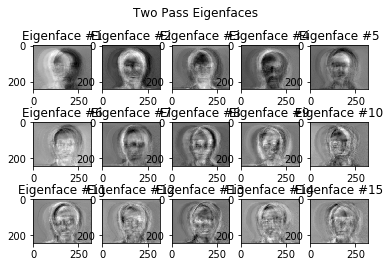

In [123]:
# Two pass eigenfaces
for i in range(1,16):
    plt.subplot(3,5,i)
    plt.imshow((UTwoPass[:,i-1]).reshape(243, 320),cmap="gray")
    plt.suptitle('Two Pass Eigenfaces')
    plt.title("Eigenface #%s"%i)
plt.show()

In [70]:
# Import a single image and reshape to a column vector g
# Solve the least square equation: U*s = g for s
# Where U is the eigenface matrix, then s is the linear combination component
# Show the image of g and U*s, compare the similariry
# repeat the same procedure for different algo.

In [108]:
def reconstructImage(imgDirectory, imgName, k, p, cmap):
    figs = []
    figure = plt.figure(figsize=(5,5))
    faceMatrix = imgMatrix(imgDirectory)
    img = imageio.imread(imgDirectory + "\\" +imgName)#[:,:,0]
    img = np.transpose([np.array(img.flatten())])

    plt.suptitle(imgName)
    #Classical
    u0,d,v0,e = classical(faceMatrix,k)
    
    sol0 = np.linalg.lstsq(u0,img,rcond=None)[0]
    plt.subplot(2,2,1)
    plt.title("Classical")
    plt.axis('off')
    plt.imshow((u0@sol0).reshape(243,320),cmap=cmap)
    
    #Algo 1
    U, D, V,Q = Fig1_svd(faceMatrix, k, p)
    sol = np.linalg.lstsq(U,img,rcond=None)[0]
    plt.subplot(2,2,2)
    plt.title("Algorithm 1")
    plt.axis('off')
    plt.imshow((U@sol).reshape(243,320),cmap=cmap)
    
    #Algo 2
    u2,d2,v2 = Fig3_svd_1(faceMatrix, k, p)[:3]
    sol = np.linalg.lstsq(U,img,rcond=None)[0]
    plt.subplot(2,2,3)
    plt.title("Algorithm 2")
    plt.axis('off')
    plt.imshow((u2@sol).reshape(243,320),cmap=cmap)
    
    #Original
    plt.subplot(2,2,4)
    plt.title("Original")
    plt.axis('off')
    plt.imshow(img.reshape(243,320),cmap=cmap)
    
    #plt.savefig("test.png", bbox_inches='tight')


In [124]:
images = ['subject01.glasses.gif','subject02.happy.gif','subject05.centerlight.gif','subject15.wink.gif']

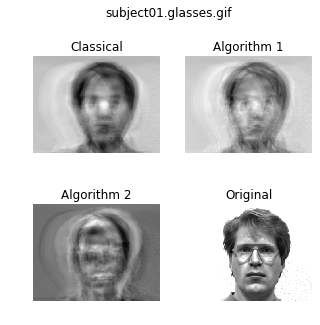

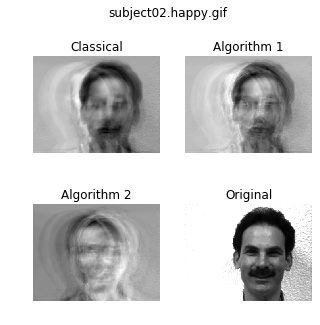

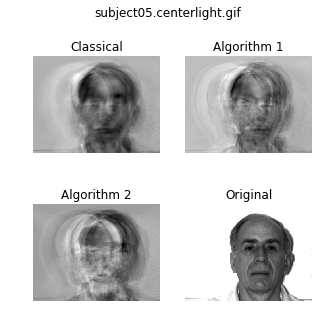

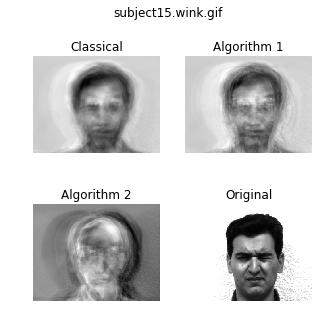

In [125]:
# Test our reconstruction on four images from the Yale Face Database
for img in images:
    reconstructImage(faceDir,img,15,30,"gray")